# PROYECTO ETAPA 3

In [4]:
pip install psutil


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 1. Descripción del problema

- Formulación matemática del CVRP
- Características de la instancia base
- Restricciones y consideracione

## 2. Implementación del Capacitated Vehicle Routing Problem (CVRP) utilizando un método metaheurístico basado en Búsqueda Local Iterativa (ILS)

1. Representación de Soluciones: Las soluciones se representan como una lista de rutas, donde cada ruta es una lista de nodos visitados por un vehículo, comenzando y terminando en el depósito.

2. Operadores:

- Búsqueda Local (2-opt): Mejora las rutas intercambiando segmentos de nodos dentro de una ruta.

- Perturbación: Intercambia nodos entre rutas para escapar de óptimos locales.

3. Heurística de Reparación: La solución inicial se genera respetando la capacidad máxima de los vehículos.

4. Gráficos de Convergencia: Se registra el costo de la mejor solución en cada iteración para visualizar la evolución del algoritmo.

In [15]:
import json

# Cargar el archivo JSON
with open('../json-resultados-api/distancias-tiempo-api.json', 'r') as f:
    data = json.load(f)

# Crear la variable grafo
grafo1 = {}

for origen, destinos in data.items():
    grafo1[int(origen)] = {}
    for destino, valores in destinos.items():
        distancia = valores['distance_km']
        tiempo = valores['time_min']
        if distancia == 0.0:
            distancia = 999.0
        if tiempo == 0.0:
            tiempo = 999.0
        grafo1[int(origen)][int(destino)] = (distancia, tiempo)





Mejor solución encontrada:
 Vehículo 1: [0, 17, 4, 22, 19, 7, 21, 12, 20, 0]
 Vehículo 2: [0, 3, 15, 1, 10, 16, 24, 11, 9, 5, 0]
 Vehículo 3: [0, 14, 23, 2, 13, 6, 18, 8, 0]

Costo total: 3746550.00
Tiempo de ejecución: 2.19 segundos
Consumo de memoria después: 31.05 MB


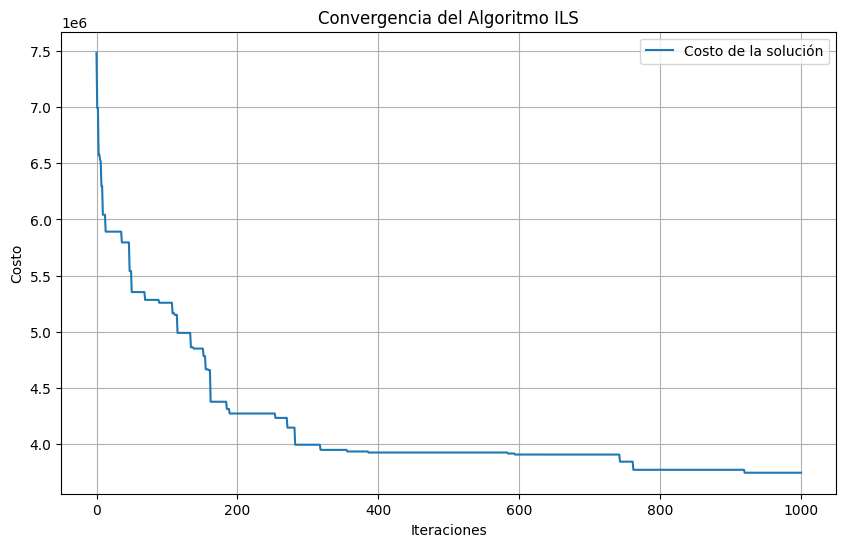

In [19]:
# =============================
# Módulo de Representación
# =============================

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
import psutil

# Configuración de la semilla para reproducibilidad
SEED = 42
random.seed(SEED)

# Definición de parámetros del algoritmo ILS
ITERACIONES = 1000  # Número total de iteraciones del algoritmo ILS
PERTURBACION = 2    # Número de nodos a intercambiar durante la perturbación

# =============================
# Módulo de Entrada de Datos
# =============================

# Cargar datos de clientes y vehículos desde archivos CSV
clients = pd.read_csv("../data-caso1/clients.csv")
vehicles = pd.read_csv("../data-caso1/vehicles.csv")

# Extraer listas de IDs y crear lista de nodos (incluyendo depósito)
clientes = clients["ClientID"].tolist()
vehiculos = vehicles["VehicleID"].tolist()
nodos = [0] + clientes  # Nodo 0 representa el depósito

# Crear diccionarios para demanda por cliente y capacidad por vehículo
demanda = dict(zip(clients["ClientID"], clients["Demand"]))
capacidad = dict(zip(vehicles["VehicleID"], vehicles["Capacity"]))



# =============================
# Módulo de Evaluación
# =============================

# Parámetros adicionales
PRECIO_COMBUSTIBLE = 15000  # Precio del combustible por litro
COSTO_MANTENIMIENTO = 700   # Costo de mantenimiento por km
COSTO_ELECTRICO = 0         # Costo eléctrico (si aplica)
TARIFA_FIJA = 5000          # Tarifa fija por km
COSTO_TIEMPO = 0            # Costo por tiempo (si aplica)
# Crear matrices de distancias y tiempos (asegúrate de que grafo1 esté definido correctamente)
distancias = {(i, j): grafo1[i][j][0] for i in grafo1 for j in grafo1[i] if i != j}
tiempos = {(i, j): grafo1[i][j][1] for i in grafo1 for j in grafo1[i] if i != j}

# Función para calcular el costo total de una solución (incluyendo costos adicionales)
def calcular_costo(rutas):
    costo_total = 0
    for ruta in rutas:
        for i in range(len(ruta) - 1):
            nodo_origen = ruta[i]
            nodo_destino = ruta[i + 1]
            
            # Acceso a distancias y tiempos
            distancia = distancias[(nodo_origen, nodo_destino)]
            tiempo = tiempos[(nodo_origen, nodo_destino)]
            
            # Cálculo del costo para este tramo
            costo_tramo = (
                PRECIO_COMBUSTIBLE * distancia +  # Costo por combustible
                COSTO_MANTENIMIENTO +            # Costo de mantenimiento
                COSTO_ELECTRICO +                # Costo eléctrico (si aplica)
                TARIFA_FIJA +                    # Tarifa fija
                COSTO_TIEMPO * tiempo            # Costo por tiempo (si aplica)
            )
            costo_total += costo_tramo
    return costo_total


# Función para verificar si las rutas son factibles según la capacidad de los vehículos
def es_factible(rutas):
    for idx, ruta in enumerate(rutas):
        carga_total = sum(demanda.get(nodo, 0) for nodo in ruta if nodo != 0)
        if carga_total > capacidad[vehiculos[idx]]:
            return False
    return True


# =============================
# Módulo de Representación (Solución Inicial)
# =============================

# Función para generar solución inicial usando heurística de inserción
def generar_solucion_inicial():
    rutas = []
    clientes_pendientes = set(clientes)
    vehiculo_idx = 0
    while clientes_pendientes and vehiculo_idx < len(vehiculos):
        ruta = [0]  # Inicia en el depósito
        carga_actual = 0
        capacidad_vehiculo = capacidad[vehiculos[vehiculo_idx]]
        clientes_a_eliminar = set()
        for cliente in clientes_pendientes:
            if carga_actual + demanda[cliente] <= capacidad_vehiculo:
                ruta.append(cliente)
                carga_actual += demanda[cliente]
                clientes_a_eliminar.add(cliente)
        ruta.append(0)  # Retorna al depósito
        rutas.append(ruta)
        clientes_pendientes -= clientes_a_eliminar
        vehiculo_idx += 1
    return rutas


# =============================
# Módulo de Operadores
# =============================

# Operador de búsqueda local (2-opt aplicado a cada ruta)
def busqueda_local(rutas):
    mejor_costo = calcular_costo(rutas)
    mejor_rutas = copy.deepcopy(rutas)
    for idx, ruta in enumerate(rutas):
        for i in range(1, len(ruta) - 2):
            for j in range(i + 1, len(ruta) - 1):
                nueva_ruta = ruta[:i] + ruta[i:j + 1][::-1] + ruta[j + 1:]
                nuevas_rutas = copy.deepcopy(rutas)
                nuevas_rutas[idx] = nueva_ruta
                if es_factible(nuevas_rutas):
                    nuevo_costo = calcular_costo(nuevas_rutas)
                    if nuevo_costo < mejor_costo:
                        mejor_costo = nuevo_costo
                        mejor_rutas = nuevas_rutas
    return mejor_rutas

# Operador de perturbación (intercambio aleatorio de clientes entre rutas)
def perturbacion(rutas):
    nuevas_rutas = copy.deepcopy(rutas)
    for _ in range(PERTURBACION):
        rutas_con_clientes = [ruta for ruta in nuevas_rutas if len(ruta) > 3]
        if len(rutas_con_clientes) < 2:
            continue
        ruta1, ruta2 = random.sample(rutas_con_clientes, 2)
        idx1 = random.randint(1, len(ruta1) - 2)
        idx2 = random.randint(1, len(ruta2) - 2)
        ruta1[idx1], ruta2[idx2] = ruta2[idx2], ruta1[idx1]
    return nuevas_rutas


# =============================
# Módulo de Algoritmo (ILS)
# =============================

# Implementación del algoritmo Iterated Local Search (ILS)
def ils():
    solucion_actual = generar_solucion_inicial()
    mejor_solucion = copy.deepcopy(solucion_actual)
    mejor_costo = calcular_costo(mejor_solucion)
    costos = [mejor_costo]  # Registro para graficar convergencia
    for iteracion in range(ITERACIONES):
        solucion_vecina = busqueda_local(solucion_actual)
        costo_vecino = calcular_costo(solucion_vecina)
        if costo_vecino < mejor_costo:
            mejor_solucion = copy.deepcopy(solucion_vecina)
            mejor_costo = costo_vecino
        solucion_actual = perturbacion(mejor_solucion)
        costos.append(mejor_costo)
    return mejor_solucion, mejor_costo, costos


# =============================
# Módulo de Experimentación
# =============================

# Medir tiempo de ejecución del algoritmo
start_time = time.time()
process = psutil.Process()  # Obtener el proceso actual
mem_before = process.memory_info().rss / (1024 * 1024)  # Memoria antes (en MB)

mejor_solucion, mejor_costo, costos = ils()

mem_after = process.memory_info().rss / (1024 * 1024)  # Memoria después (en MB)
end_time = time.time()

# Mostrar resultados por consola
print("\nMejor solución encontrada:")
for i, ruta in enumerate(mejor_solucion):
    print(f" Vehículo {vehiculos[i]}: {ruta}")
print(f"\nCosto total: {mejor_costo:.2f}")
print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")

print(f"Consumo de memoria después: {mem_after:.2f} MB")



# =============================
# Módulo de Visualización
# =============================

# Graficar convergencia del algoritmo (evolución del costo)
plt.figure(figsize=(10, 6))
plt.plot(costos, label="Costo de la solución")
plt.xlabel("Iteraciones")
plt.ylabel("Costo")
plt.title("Convergencia del Algoritmo ILS")
plt.legend()
plt.grid()
plt.savefig("convergencia_ils.png")
plt.show()


### Gráfico de rutas con ILS

/var/folders/zm/ycnc3kk55kl_sql6gtln4m_40000gn/T/ipykernel_96199/2885140635.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10', len(mejor_solucion))


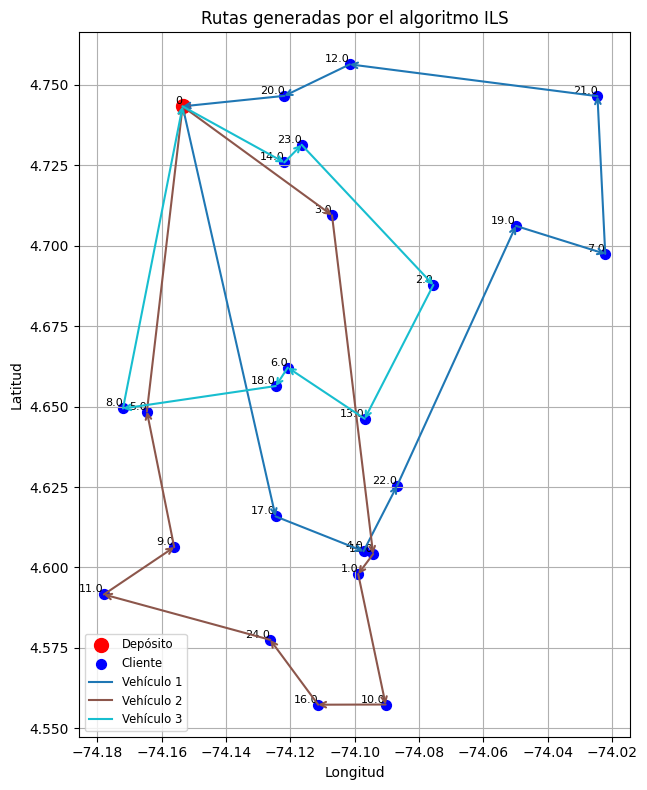

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Cargar datos de clientes y depósitos
clients = pd.read_csv('../data-caso1/clients.csv')
depots = pd.read_csv('../data-caso1/depots.csv')

# Obtener coordenadas de los nodos
depot = depots.iloc[0]
coords = {0: (depot.Longitude, depot.Latitude)}
for _, row in clients.iterrows():
    coords[row.ClientID] = (row.Longitude, row.Latitude)

# Figura
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar nodos
for node, (x, y) in coords.items():
    if node == 0:
        ax.scatter(x, y, c='red', s=100, label='Depósito')
    else:
        label = 'Cliente' if 'Cliente' not in ax.get_legend_handles_labels()[1] else ""
        ax.scatter(x, y, c='blue', s=50, label=label)
    ax.text(x, y, str(node), fontsize=8, ha='right', va='bottom')

# Graficar rutas
cmap = get_cmap('tab10', len(mejor_solucion))
for idx, ruta in enumerate(mejor_solucion):
    color = cmap(idx)
    for i in range(len(ruta) - 1):
        x1, y1 = coords[ruta[i]]
        x2, y2 = coords[ruta[i + 1]]
        ax.annotate(
            '', 
            xy=(x2, y2), 
            xytext=(x1, y1),
            arrowprops=dict(
                arrowstyle='->',
                color=color,
                lw=1.5,
                shrinkA=0, shrinkB=0
            ),
            annotation_clip=False
        )
    ax.plot([], [], color=color, lw=1.5, label=f'Vehículo {idx + 1}')

# Configuración del gráfico
ax.set_title('Rutas generadas por el algoritmo ILS')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend(loc='best', fontsize='small')
ax.grid(True)
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

## 3. Resultados experimentales

## Plan Experimental para Calibración y Experimentación del Algoritmo ILS

El objetivo es calibrar los parámetros del algoritmo Búsqueda Local Iterativa (ILS) y evaluar su desempeño en términos de calidad de solución, tiempo de ejecución y estabilidad. A continuación, se describe el plan experimental:

1. Parámetros a Calibrar

Los parámetros clave del algoritmo ILS que se evaluarán son:

- Número de Iteraciones (ITERACIONES): Define cuántas iteraciones realizará el algoritmo.
- Nivel de Perturbación (PERTURBACION): Número de nodos intercambiados entre rutas en la fase de perturbación.
- Semillas Aleatorias (SEED): Para garantizar la reproducibilidad y evaluar la estabilidad del algoritmo.

2. Configuraciones de Parámetros

Se probarán las siguientes configuraciones:

| Configuración | Iteraciones (ITERACIONES) | Perturbación (PERTURBACION) |
|---------------|---------------------------|-----------------------------|
| Config 1      | 500                       | 2                           |
| Config 2      | 1000                      | 2                           |
| Config 3      | 1000                      | 3                           |
| Config 4      | 1500                      | 3                           |


3. Métricas a Registrar

Para cada configuración, se registrarán las siguientes métricas:

- Mejor Costo: El menor costo encontrado en las corridas.
- Peor Costo: El mayor costo encontrado en las corridas.
- Costo Promedio: Promedio de los costos obtenidos en las corridas.
- Desviación Estándar del Costo: Variabilidad de los costos.
- Tiempo de Ejecución: Tiempo total en segundos para cada corrida.

4. Plan de Ejecución

- Número de Corridas: Se realizarán 3 corridas independientes por configuración, utilizando semillas distintas para cada corrida.
- Semillas Aleatorias: Se usarán las semillas [42, 123, 456] para garantizar la reproducibilidad.

5. Código para Calibración y Experimentación

Ejecutando configuración: Iteraciones=500, Perturbación=2
Ejecutando configuración: Iteraciones=1000, Perturbación=2
Ejecutando configuración: Iteraciones=1000, Perturbación=3
Ejecutando configuración: Iteraciones=1500, Perturbación=3

Resultados del Experimento:
   iteraciones  perturbacion  mejor_costo  peor_costo  promedio_costo  \
0          500             2    3891450.0   4106400.0       3974750.0   
1         1000             2    3715650.0   3920550.0       3794250.0   
2         1000             3    4032150.0   4307550.0       4168600.0   
3         1500             3    3946650.0   4129800.0       4031900.0   

   desviacion_costo  promedio_tiempo  
0      94177.730913         1.048916  
1      90194.123977         2.129052  
2     112445.475676         2.005778  
3      75303.817964         2.967865  


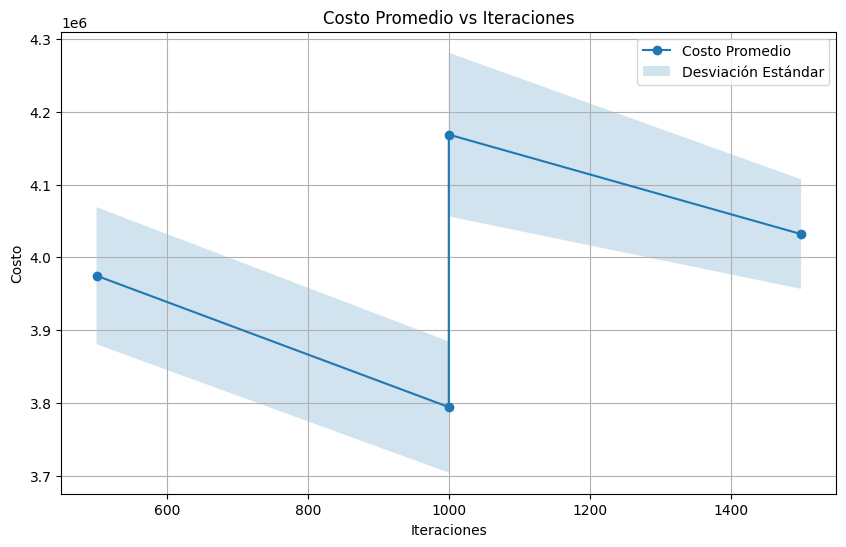

In [18]:
# =============================
# Función para ejecutar el experimento
# =============================
def ejecutar_experimento(iteraciones, perturbacion, semillas):
    resultados = []
    for seed in semillas:
        random.seed(seed)
        np.random.seed(seed)
        
        # Configurar parámetros
        global ITERACIONES, PERTURBACION
        ITERACIONES = iteraciones
        PERTURBACION = perturbacion
        
        # Ejecutar el algoritmo ILS
        start_time = time.time()
        mejor_solucion, mejor_costo, _ = ils()
        end_time = time.time()
        
        # Registrar resultados
        tiempo_ejecucion = end_time - start_time
        resultados.append((mejor_costo, tiempo_ejecucion))
    
    return resultados

# =============================
# Función para calibrar parámetros
# =============================
def calibrar_parametros():
    # Configuraciones a probar
    configuraciones = [
        {"iteraciones": 500, "perturbacion": 2},
        {"iteraciones": 1000, "perturbacion": 2},
        {"iteraciones": 1000, "perturbacion": 3},
        {"iteraciones": 1500, "perturbacion": 3},
    ]

    # Semillas para las corridas
    semillas = [42, 123, 456]

    # Ejecutar experimentos
    resultados_experimentos = []
    for config in configuraciones:
        print(f"Ejecutando configuración: Iteraciones={config['iteraciones']}, Perturbación={config['perturbacion']}")
        resultados = ejecutar_experimento(config["iteraciones"], config["perturbacion"], semillas)
        
        # Calcular estadísticas
        costos = [r[0] for r in resultados]
        tiempos = [r[1] for r in resultados]
        mejor_costo = min(costos)
        peor_costo = max(costos)
        promedio_costo = np.mean(costos)
        desviacion_costo = np.std(costos)
        promedio_tiempo = np.mean(tiempos)
        
        # Guardar resultados
        resultados_experimentos.append({
            "iteraciones": config["iteraciones"],
            "perturbacion": config["perturbacion"],
            "mejor_costo": mejor_costo,
            "peor_costo": peor_costo,
            "promedio_costo": promedio_costo,
            "desviacion_costo": desviacion_costo,
            "promedio_tiempo": promedio_tiempo,
        })

    # Mostrar resultados
    print("\nResultados del Experimento:")
    df_resultados = pd.DataFrame(resultados_experimentos)
    print(df_resultados)

    # Guardar resultados en un archivo CSV
    df_resultados.to_csv("resultados_experimentos_ils.csv", index=False)

    # Graficar resultados
    plt.figure(figsize=(10, 6))
    plt.plot(df_resultados["iteraciones"], df_resultados["promedio_costo"], marker="o", label="Costo Promedio")
    plt.fill_between(df_resultados["iteraciones"],
                     df_resultados["promedio_costo"] - df_resultados["desviacion_costo"],
                     df_resultados["promedio_costo"] + df_resultados["desviacion_costo"],
                     alpha=0.2, label="Desviación Estándar")
    plt.xlabel("Iteraciones")
    plt.ylabel("Costo")
    plt.title("Costo Promedio vs Iteraciones")
    plt.legend()
    plt.grid()
    plt.savefig("costo_vs_iteraciones.png")
    plt.show()

# =============================
# Ejecutar la calibración de parámetros
# =============================
calibrar_parametros()

### 3.1 Comparación meautrística y método pyomo

Se ejecutó nuevamente la implementación del primer punto del proyecto etapa 2, es decir el método implementado en pyomo, y se obtuvo lo siguiente:

![método pyomo](resultadométodopyomo.png)

**1. Comparación Cuantitativa**

- **Datos de Resultados**

| Métrica             | Metaheurística (ILS) | Pyomo        |
|---------------------|----------------------|--------------|
| Costo Total         |  3,746,550.00              | 4,194,750.0  |
| Tiempo de Ejecución | 2.33 segundos        | 60.4 segundos|
| Número de Vehículos usados | 3                    | 3            |
| Uso de memoria |  31.08 Mb                   | 49.9 Mb           |


- **Calidad de la Solución**

En cuanto a la calidad de la solución, ILS obtiene un costo total  menor (3746550.00) en comparación con Pyomo (4,194,750.0), lo que sugiere que la metaheurística es más efectiva para este caso específico. 


- **Tiempo de Ejecución:**

En términos de tiempo de ejecución, ILS es notablemente más rápido, resolviendo el problema en solo 2.33 segundos frente a los 60.4 segundos que requiere Pyomo, lo que lo hace más adecuado para escenarios donde la rapidez es crucial.


- **Uso de memoria:**

En cuanto al uso de memoria, ILS también es más eficiente, consumiendo 31.08 MB frente a los 49.9 MB de Pyomo, lo que lo convierte en una opción más ligera en términos de recursos computacionales. 

- **Comparación de caminos**

1. Método pyomo:

![Gráfica método pyomo](graficarutasmetodopyomo.png)

2. ILS: 

![Gráfica método pyomo](graficarutasils.png)






### Discusión 

En cuanto al costo total, la metaheurística ILS logra un valor menor (3,746,550.00) en comparación con Pyomo (4,194,750.0). Esto sugiere que, para este caso específico, ILS es más eficiente en la optimización del costo, posiblemente debido a su capacidad para explorar soluciones cercanas al óptimo de manera iterativa. Sin embargo, es importante considerar que Pyomo utiliza un enfoque exacto que garantiza una solución óptima dentro de las restricciones definidas, mientras que ILS puede sacrificar precisión en favor de la rapidez.

Respecto al tiempo de ejecución, ILS es notablemente más rápido, resolviendo el problema en solo 2.33 segundos frente a los 60.4 segundos requeridos por Pyomo. Esto hace que ILS sea una opción más adecuada para escenarios donde la rapidez es crucial, como en aplicaciones en tiempo real o con grandes volúmenes de datos. Pyomo, al ser un método exacto, requiere más tiempo debido a la construcción y resolución del modelo matemático.

En términos de uso de memoria, ILS también es más eficiente, consumiendo 31.08 MB frente a los 49.9 MB de Pyomo. Esto lo convierte en una opción más ligera en términos de recursos computacionales, lo que puede ser ventajoso en sistemas con limitaciones de hardware.

Al comparar las rutas generadas, ambos métodos utilizan tres vehículos, pero las rutas asignadas difieren. En el caso de Pyomo, las rutas parecen más estructuradas y optimizadas en términos de agrupación geográfica, lo que refleja el enfoque exacto del modelo. Por otro lado, las rutas generadas por ILS muestran una distribución diferente, que podría ser menos precisa pero aún factible y eficiente en términos de costos. Esto es consistente con el enfoque heurístico de ILS, que busca soluciones cercanas al óptimo sin garantizar la perfección.

En conclusión, la metaheurística ILS destaca por su rapidez y eficiencia en el uso de memoria, logrando además un menor costo total en este caso. Sin embargo, Pyomo ofrece una solución más robusta y estructurada, aunque a un mayor costo computacional y de tiempo.

---

### 3.2 Comportamiento al escalar (Casos 2 y 3) Probar con los datos para caso 2 y 3 y comparar pyomo y metodo metaheuristica( tiempo, convergencia, memoria, etc)

---
### 3.3 Analice diferencias cualitativas en las rutas según los resultados (longitud, número de vehículos,balance de carga)

---
### 3.4 Evaluar Rendimiento en instancias de diferentes tamaños y  Límites prácticos de aplicabilidad

## 4. Análisis de Escalabilidad

- Estrategias para mejorar la escalabilidad
- Análisis de degradación de rendimiento
- Conclusiones sobre aplicabilidad para problemas reales
- Es importante discutir las siguientes consideraciones de complejidad:
- Complejidad teórica: Analizar la complejidad algorítmica de los métodos
implementados.
- Complejidad práctica: Evaluar el comportamiento real en términos de tiem-
po y memoria

## 5. Discusión

#### 5.1 Ventajas y desventajas de cada enfoque

(ANÁLISIS SIN ESCALAMIENTO)

- Metaheurística ILS:

**Ventajas:**
Alta velocidad de ejecución (2.33 segundos), lo que la hace ideal para problemas donde el tiempo de respuesta es crítico.
Bajo consumo de memoria (31.08 MB), lo que la convierte en una opción eficiente para sistemas con recursos limitados.
Flexibilidad para adaptarse a diferentes problemas mediante ajustes en los parámetros y operadores.

**Desventajas:**
No garantiza encontrar la solución óptima, ya que es un enfoque heurístico.
La calidad de la solución puede depender de la configuración de los parámetros (como el número de iteraciones y la perturbación).
Las rutas generadas pueden ser menos estructuradas en comparación con métodos exactos.


- Pyomo (Optimización Exacta):

**Ventajas:**
Garantiza una solución óptima dentro de las restricciones definidas.
Las rutas generadas suelen ser más estructuradas y geográficamente coherentes.
Es adecuado para problemas donde la precisión es prioritaria.

**Desventajas:**
Tiempo de ejecución significativamente mayor (60.4 segundos), lo que puede ser un problema en aplicaciones en tiempo real.
Mayor consumo de memoria (49.9 MB), lo que puede ser una limitación en sistemas con hardware restringido.
Requiere un conocimiento más avanzado para formular y resolver el modelo matemático.

#### 5.2 Recomendaciones para diferentes escenario

Usar ILS: 

* En problemas donde el tiempo de respuesta es crítico, como en aplicaciones en tiempo real o con grandes volúmenes de datos.
* En sistemas con recursos computacionales limitados, donde el uso de memoria debe ser minimizado.
* En casos donde una solución cercana al óptimo es suficiente y no se requiere precisión absoluta.

Usar método de Pyomo:

* En problemas donde la precisión y la robustez de la solución son prioritarias.
* En escenarios donde el tiempo de ejecución no es una restricción importante.
* En problemas complejos con múltiples restricciones que requieren un enfoque exacto para garantizar la factibilidad.

#### 5.3 Lecciones aprendidas 

- La elección del enfoque depende en gran medida de las prioridades del problema (velocidad vs. precisión).
- Las metaheurísticas como ILS son herramientas poderosas para obtener soluciones rápidas y eficientes, pero requieren ajustes cuidadosos de los parámetros.
- Los métodos exactos como Pyomo son ideales para garantizar soluciones óptimas, pero pueden ser computacionalmente costosos.

#### 5.4  desafíos encontrados

- La implementación de ILS requiere un diseño cuidadoso de los operadores de búsqueda local y perturbación para garantizar la calidad de las soluciones.
- En Pyomo, la formulación del modelo matemático puede ser compleja, especialmente al manejar restricciones como el flujo de vehículos y la capacidad.
- Comparar los resultados de ambos enfoques puede ser complicado debido a las diferencias en cómo se calculan los costos y se generan las rutas.




## 6. Conclusiones

Resumen de hallazgos principales
Respuestas a preguntas estratégicas
Direcciones futuras de investigació

- Sobre el análisis realizado antes de escalar,  ILS demostró ser una solución eficiente en términos de tiempo de ejecución y uso de memoria, logrando además un costo total menor. Sin embargo, su naturaleza heurística implica que no garantiza la solución óptima, lo que podría ser más evidente en problemas de mayor escala. Pyomo, por su parte, destacó por su capacidad para garantizar soluciones óptimas y generar rutas más estructuradas y coherentes, aunque a costa de un mayor tiempo de ejecución y consumo de memoria. Este enfoque es más adecuado para problemas donde la precisión es prioritaria y los recursos computacionales no son una limitación. 